In [1]:

import tinygp
import jax.numpy as jnp
import numpy as np

import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax.numpy as jnp
import tinygp
from mind_the_gaps.gpmodelling import  GPModellingComparison
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)
from mind_the_gaps.simulator import Simulator

from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian




/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Case of No period

# Define parameters for lightcurve simulation

In [2]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]

mean = 100

#A = (mean * 0.1) ** 2 # variance of the lorentzian
#Q = 80
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

# define the PSD model
psd_model = BendingPowerlaw(variance_drw, w_bend) 

# Simulate lightcurve

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Rates (ct/s)')

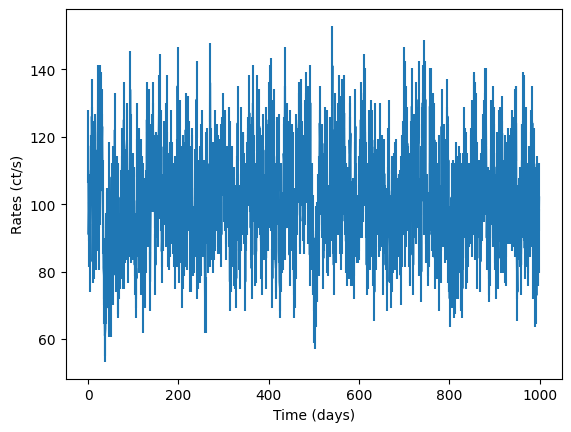

In [3]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", 
                     extension_factor=2)
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)

input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null and alternative hypothesis

In [4]:
# null 
null_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=tinygp.kernels.quasisep.Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-1.0, 10.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                    "d": KernelParameterSpec(value=-1e20, zeroed=True),
                },
            )
        ],
    )

P = 10 # period of the QPO
w = 2 * np.pi / P
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
Q = 80 # coherence
log_c = np.log(0.5 * w/Q)
log_d = np.log(w)

alt_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=tinygp.kernels.quasisep.Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-1, 10.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                    "d": KernelParameterSpec(value=-1e20, zeroed=True),
                },
            ),
            KernelTermSpec(
                term_class=tinygp.kernels.quasisep.Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=log_variance_qpo,
                        prior=dist.Uniform,
                        bounds=(-1, 10.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=log_c,
                        prior=dist.Uniform,
                        bounds=(-1.0, 10.0),
                    ),
                    "d": KernelParameterSpec(
                        value=log_d,
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                },
            ),
        ],
    )

# Set up GP Model Comparison

In [5]:

gp_model_comp = GPModellingComparison(
        null_kernel_spec=null_kernel_spec,
        alt_kernel_spec=alt_kernel_spec,
        lightcurve=input_lc,
        null_mean_params=jnp.array([input_lc.mean]),
        alt_mean_params=jnp.array([input_lc.mean]),
        fit_mean=True,
        meanmodel="Constant"
    )

# Derive posteriors for both models lightcurves from null hypothesis posteriors

In [7]:
gp_model_comp.derive_posteriors(
        fit=True, max_steps=50000, num_chains=20, burnin=1000, converge_steps=1000,  progress=True, aies=True
    )

sample: 100%|██████████| 2000/2000 [00:05<00:00, 362.73it/s, acc. prob=0.51]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 534.55it/s, acc. prob=0.52]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 516.67it/s, acc. prob=0.52]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 527.68it/s, acc. prob=0.52]


MCMC not converged after 4000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 506.55it/s, acc. prob=0.52]


MCMC not converged after 5000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 533.46it/s, acc. prob=0.52]


MCMC not converged after 6000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 533.61it/s, acc. prob=0.52]


MCMC not converged after 7000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 534.21it/s, acc. prob=0.52]


MCMC not converged after 8000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 527.24it/s, acc. prob=0.51]


MCMC not converged after 9000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 515.22it/s, acc. prob=0.51]


MCMC not converged after 10000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 526.49it/s, acc. prob=0.51]


MCMC not converged after 11000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 514.77it/s, acc. prob=0.51]


MCMC not converged after 12000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 534.17it/s, acc. prob=0.51]


MCMC not converged after 13000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 533.70it/s, acc. prob=0.51]


MCMC not converged after 14000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 523.46it/s, acc. prob=0.51]


MCMC not converged after 15000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 519.16it/s, acc. prob=0.51]


MCMC not converged after 16000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 519.29it/s, acc. prob=0.52]


MCMC not converged after 17000 steps.


sample: 100%|██████████| 1000/1000 [00:01<00:00, 528.86it/s, acc. prob=0.52]


MCMC converged after 18000 steps.


sample: 100%|██████████| 2000/2000 [00:32<00:00, 61.01it/s, acc. prob=0.40]


MCMC not converged after 1000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.69it/s, acc. prob=0.41]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.60it/s, acc. prob=0.41]


MCMC not converged after 3000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.36it/s, acc. prob=0.41]


MCMC not converged after 4000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s, acc. prob=0.41]


MCMC not converged after 5000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.02it/s, acc. prob=0.41]


MCMC not converged after 6000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.69it/s, acc. prob=0.41]


MCMC not converged after 7000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s, acc. prob=0.41]


MCMC not converged after 8000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.49it/s, acc. prob=0.41]


MCMC not converged after 9000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.37it/s, acc. prob=0.41]


MCMC not converged after 10000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.83it/s, acc. prob=0.41]


MCMC not converged after 11000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.49it/s, acc. prob=0.41]


MCMC not converged after 12000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 65.96it/s, acc. prob=0.41]


MCMC not converged after 13000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 63.38it/s, acc. prob=0.41]


MCMC not converged after 14000 steps.


sample: 100%|██████████| 1000/1000 [00:16<00:00, 61.54it/s, acc. prob=0.41]


MCMC not converged after 15000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.98it/s, acc. prob=0.41]


MCMC not converged after 16000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.00it/s, acc. prob=0.41]


MCMC not converged after 17000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.67it/s, acc. prob=0.41]


MCMC not converged after 18000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 65.13it/s, acc. prob=0.41]


MCMC not converged after 19000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.85it/s, acc. prob=0.41]


MCMC not converged after 20000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.40it/s, acc. prob=0.41]


MCMC not converged after 21000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.55it/s, acc. prob=0.41]


MCMC not converged after 22000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.95it/s, acc. prob=0.41]


MCMC not converged after 23000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.85it/s, acc. prob=0.41]


MCMC not converged after 24000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.06it/s, acc. prob=0.41]


MCMC not converged after 25000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.39it/s, acc. prob=0.40]


MCMC not converged after 26000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.70it/s, acc. prob=0.40]


MCMC not converged after 27000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.92it/s, acc. prob=0.40]


MCMC not converged after 28000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.24it/s, acc. prob=0.40]


MCMC not converged after 29000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.75it/s, acc. prob=0.40]


MCMC not converged after 30000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.34it/s, acc. prob=0.40]


MCMC not converged after 31000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.08it/s, acc. prob=0.40]


MCMC not converged after 32000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.06it/s, acc. prob=0.41]


MCMC not converged after 33000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 65.77it/s, acc. prob=0.41]


MCMC not converged after 34000 steps.


sample: 100%|██████████| 1000/1000 [00:15<00:00, 65.43it/s, acc. prob=0.40]


MCMC not converged after 35000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.13it/s, acc. prob=0.40]


MCMC not converged after 36000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.56it/s, acc. prob=0.40]


MCMC not converged after 37000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.88it/s, acc. prob=0.41]


MCMC not converged after 38000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.86it/s, acc. prob=0.41]


MCMC not converged after 39000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.20it/s, acc. prob=0.41]


MCMC not converged after 40000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 69.18it/s, acc. prob=0.40]


MCMC not converged after 41000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.16it/s, acc. prob=0.41]


MCMC not converged after 42000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.72it/s, acc. prob=0.41]


MCMC not converged after 43000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 69.15it/s, acc. prob=0.41]


MCMC not converged after 44000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 69.19it/s, acc. prob=0.41]


MCMC not converged after 45000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.62it/s, acc. prob=0.41]


MCMC not converged after 46000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.70it/s, acc. prob=0.41]


MCMC not converged after 47000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.43it/s, acc. prob=0.41]


MCMC not converged after 48000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.47it/s, acc. prob=0.41]


MCMC not converged after 49000 steps.


sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.68it/s, acc. prob=0.41]


MCMC not converged after 50000 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 50000 iterations!
  warnings.warn(


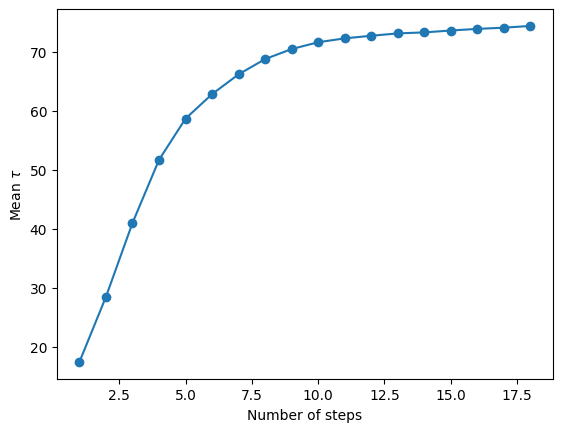

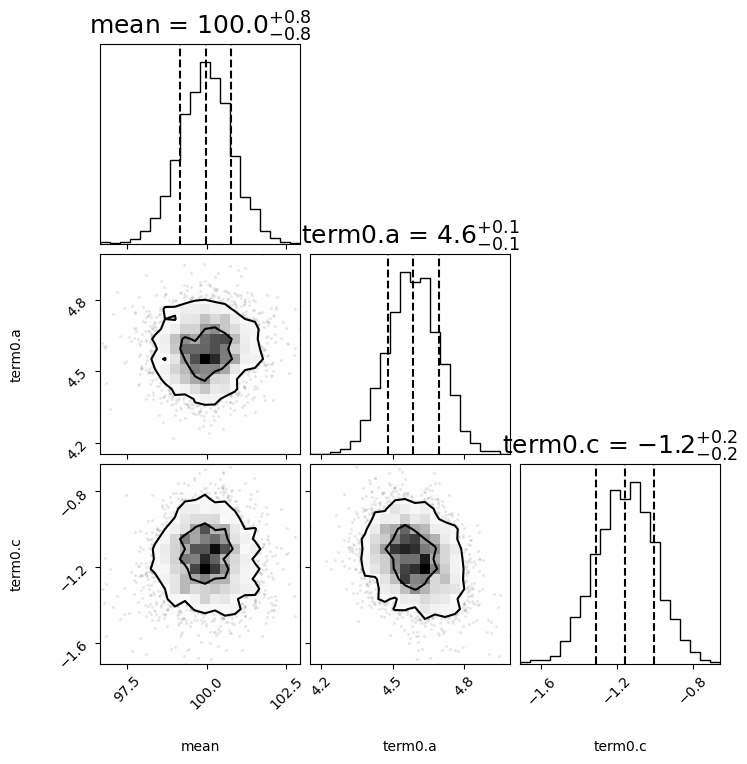

In [10]:
gp_model_comp.null_model.plot_autocorrelation()
gp_model_comp.null_model.corner_plot_samples()

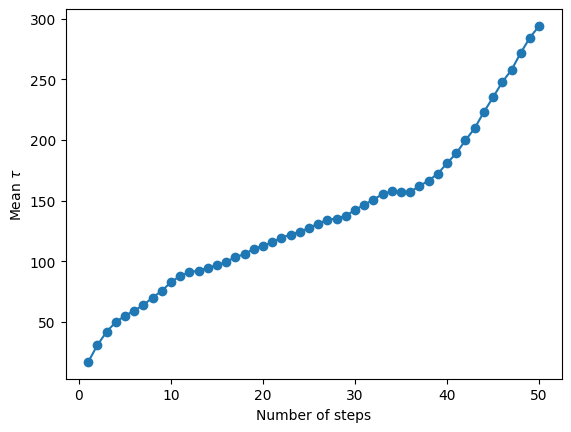

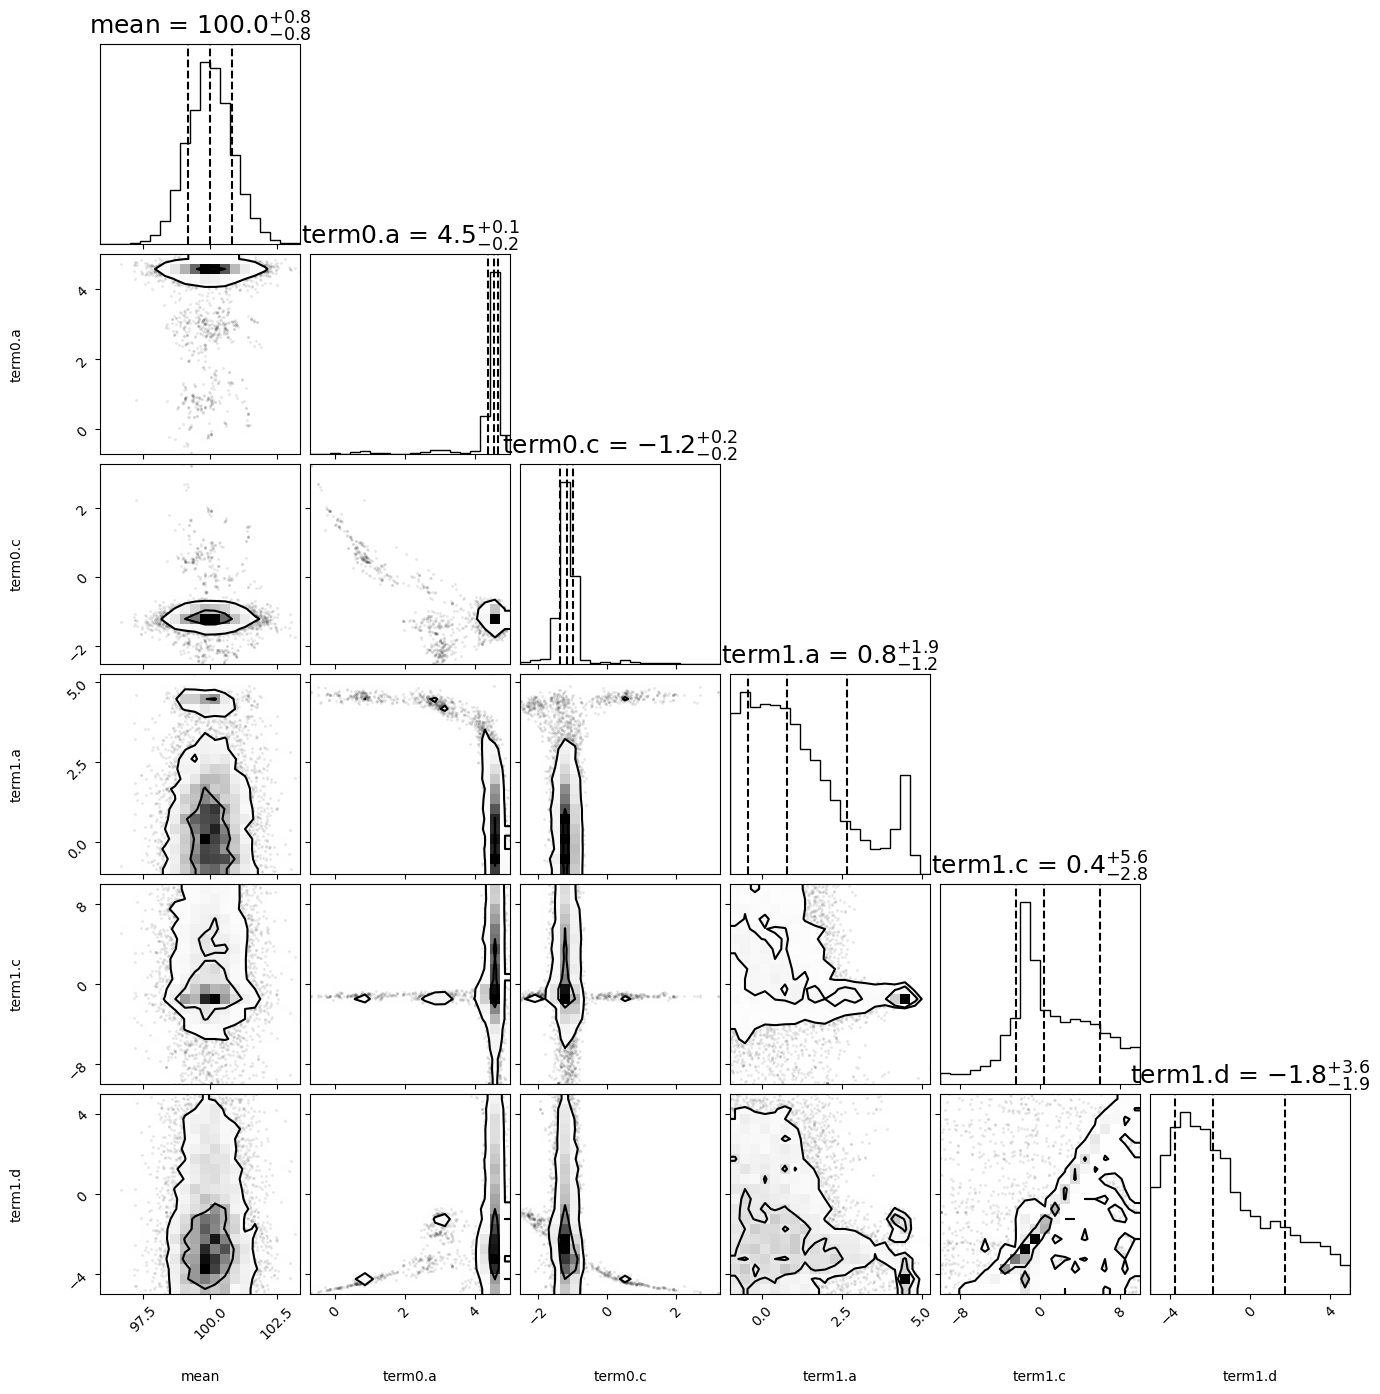

In [11]:
gp_model_comp.alt_model.plot_autocorrelation()
gp_model_comp.alt_model.corner_plot_samples()

# Generate lightcurves, and fit with both null and alternative models

In this case we perform a small MCMC using Numpyro's AIES sampler vectorized over the chains, and parallelised over 10 workers each processing a single lightcurve. 


In [14]:
gp_model_comp.process_lightcurves_par(        nsims=100,
        fit=True,
        max_steps=500,
        num_chains=20,
        burnin=0,
        converge_steps=500,
        aies=True, 
        par_workers=10,progress=False)

    import json
  File "/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/json/__init__.py", line 107, in <module>
    from .encoder import JSONEncoder
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1032, in get_code
  File "<frozen importlib._bootstrap_external>", line 1130, in get_data
KeyboardInterrupt
ImportError: _multiarray_umath failed to import
Process SpawnProcess-22:
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(mes

MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
Process SpawnProcess-40:
Process SpawnProcess-35:
Process SpawnProcess-36:
Process SpawnProcess-34:
Process SpawnProcess-32:
Process SpawnProcess-39:
Process SpawnProcess-33:
Process SpawnProcess-38:
Process SpawnProcess-37:
Process SpawnProcess-31:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/concurrent/futures/process.py", line 249, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/__init__.py", line 6, in <module>
    from .gpmodelling import GPModelling
  File "/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/gpmodelling.py", line 11, in <

MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/base_numpyro_engine.py:525: UserWarning: The chains did not converge after 500 iterations!
  warnings.warn(


# Perform Likelihood Ratio Test

In [ ]:
gp_model_comp.likelihood_ratio_test(path="LRT_no_period.png")

We see the p-value to reject the null hypothesis is fairly low, indicating there is no signal in this data, as expected

# Case with Period

# Simulate lightcurve

In [ ]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]

mean = 100

P = 10 # period of the QPO
w_qpo = 2 * np.pi / P
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
variance_qpo = variance_drw # let's assume same variance for the QPO and the DRW

Q = 80 # coherence

psd_model = Lorentzian(variance_qpo, Q, w_qpo) + BendingPowerlaw(variance_drw, w_bend) 

Text(0, 0.5, 'Rates (ct/s)')

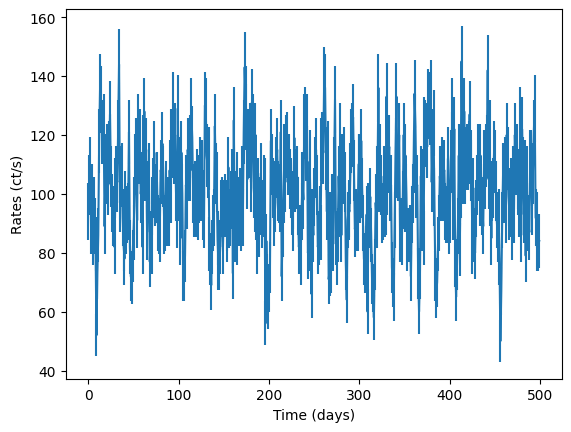

In [ ]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

In [ ]:



null_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=tinygp.kernels.quasisep.Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10.0, 50.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                    "d": KernelParameterSpec(value=-1e20, zeroed=True),
                },
            )
        ],
    )

# Define alternative model

In [ ]:
log_c = np.log(0.5 * w_qpo/Q)
log_d = np.log(w_qpo)
bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# again you may use the Lorentzian from models.celerite_models


alt_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=tinygp.kernels.quasisep.Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-1, 10.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                    "d": KernelParameterSpec(value=-1e20, zeroed=True),
                },
            ),
            KernelTermSpec(
                term_class=tinygp.kernels.quasisep.Celerite,
                parameters={
                    "a": KernelParameterSpec(
                        value=log_variance_qpo,
                        prior=dist.Uniform,
                        bounds=(-1, 10.0),
                    ),
                    "b": KernelParameterSpec(value=-1e20, zeroed=True),
                    "c": KernelParameterSpec(
                        value=log_c,
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                    "d": KernelParameterSpec(
                        value=log_d,
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                },
            ),
        ],
    )



# Set up GP Model Comparison

In [ ]:
gp_model_comp = GPModellingComparison(
        null_kernel_spec=null_kernel_spec,
        alt_kernel_spec=alt_kernel_spec,
        lightcurve=input_lc,
        null_mean_params=jnp.array([input_lc.mean]),
        alt_mean_params=jnp.array([input_lc.mean]),
        fit_mean=False,
    )

# Derive Posteriors for null and alternative models

In [ ]:
gp_model_comp.derive_posteriors(fit=True, max_steps=25000, num_chains=20, burnin=3000, converge_steps=500,  progress=False, aies=True)

 20%|██        | 10000/50000 [00:23<01:34, 423.57it/s]


Convergence reached after 10000 samples!


 25%|██▌       | 12500/50000 [00:41<02:04, 301.65it/s]


Convergence reached after 12500 samples!


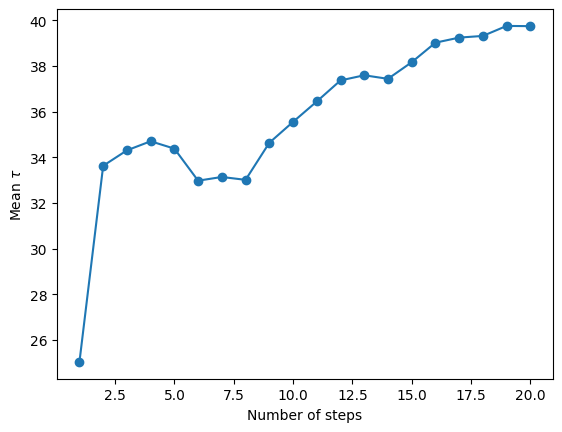

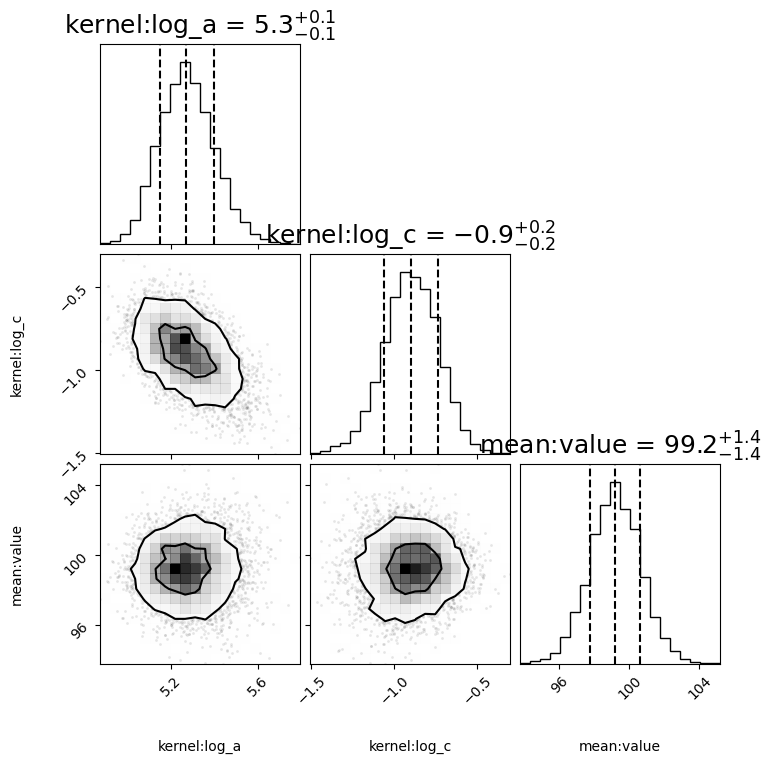

In [ ]:
gp_model_comp.null_model.plot_autocorrelation()
gp_model_comp.null_model.corner_plot_samples()

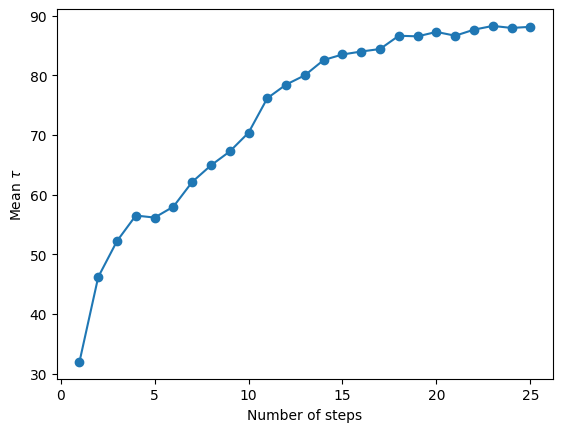

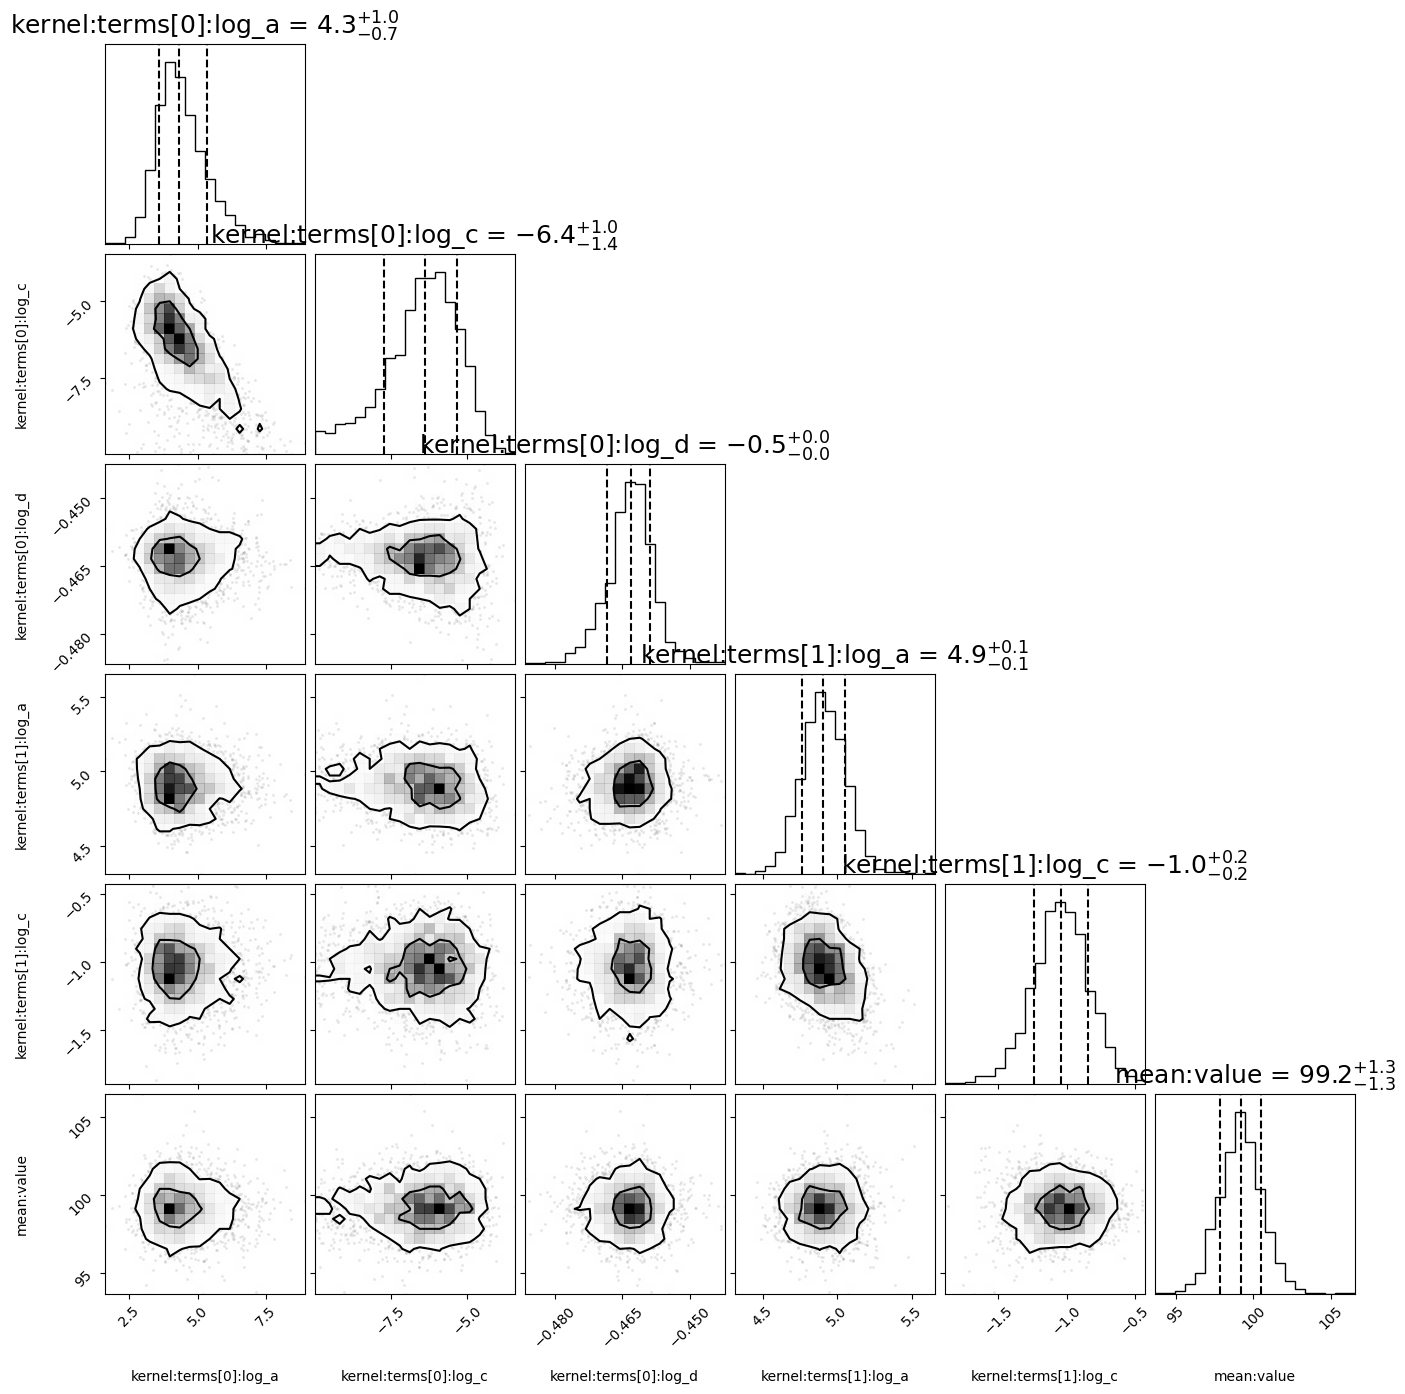

In [ ]:
gp_model_comp.alt_model.plot_autocorrelation()
gp_model_comp.alt_model.corner_plot_samples()

# Generate lightcurves, and fit with both null and alternative models

In [ ]:
gp_model_comp.process_lightcurves_par(        nsims=100,
        fit=True,
        max_steps=500,
        num_chains=20,
        burnin=500,
        converge_steps=500,
        aies=True, 
        par_workers=10)

# Perform Likelihood Ratio Test

In [ ]:
gp_model_comp.likelihood_ratio_test(path="LRT_period.png")